# sentiment analysis using LSTM

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import load_model

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re


/home/gis-local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# data set: https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment
data = pd.read_csv('./data/Sentiment.csv')
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [3]:
# we only need text and sentiment
data = data[['text', 'sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [4]:
data.groupby('sentiment').count()

,text
sentiment,
Negative,8493
Neutral,3142
Positive,2236


In [5]:
# we will drop the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. 
data = data[data.sentiment != 'Neutral']
data.groupby('sentiment').count()

,text
sentiment,
Negative,8493
Positive,2236


In [6]:
# replace re for retweet, lower case, and remove punctuations
data['text'] = data['text'].str.replace('rt',' ').str.lower().apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['text'].head()

1    rt scottwalker didnt catch the full gopdebate ...
3    rt robgeorge that carly fiorina is trending  h...
4    rt danscavino gopdebate w realdonaldtrump deli...
5    rt gregabbott_tx tedcruz on my first day i wil...
6    rt warriorwoman91 i liked her and was happy wh...
Name: text, dtype: object

In [13]:
# The Tokenizer will try to keep the most frequent 2000 words from each text, 
# but if there is not 2000 words in the text, it will pad remaining number of indexes with zeros in the produced vector.
# convert text into Sequences so the Network can deal with it as input.
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
print(X[0])
X = pad_sequences(X)
print(X.shape)
print(data['text'].values[0])
print(X[0])

[3, 363, 123, 1, 704, 2, 40, 59, 237, 38, 211, 7, 175, 1761, 13, 1324, 1409, 744]
(10729, 28)
rt scottwalker didnt catch the full gopdebate last night here are some of scotts best lines in 90 seconds walker16 httptcozsff
[   0    0    0    0    0    0    0    0    0    0    3  363  123    1
  704    2   40   59  237   38  211    7  175 1761   13 1324 1409  744]


In [9]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
Y = pd.get_dummies(data['sentiment']).values
print(Y[0])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[0 1]
(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


In [16]:
batch_size = 30
history = model.fit(X_train, Y_train, epochs = 50, batch_size=batch_size, verbose = 2)

Epoch 1/50
 - 26s - loss: 0.4414 - acc: 0.8164
Epoch 2/50
 - 24s - loss: 0.3225 - acc: 0.8655
Epoch 3/50
 - 25s - loss: 0.2822 - acc: 0.8844
Epoch 4/50
 - 25s - loss: 0.2535 - acc: 0.8958
Epoch 5/50
 - 25s - loss: 0.2321 - acc: 0.9065
Epoch 6/50
 - 25s - loss: 0.2016 - acc: 0.9165
Epoch 7/50
 - 25s - loss: 0.1861 - acc: 0.9240
Epoch 8/50
 - 26s - loss: 0.1745 - acc: 0.9304
Epoch 9/50
 - 25s - loss: 0.1594 - acc: 0.9363
Epoch 10/50
 - 25s - loss: 0.1477 - acc: 0.9373
Epoch 11/50
 - 26s - loss: 0.1394 - acc: 0.9452
Epoch 12/50
 - 28s - loss: 0.1234 - acc: 0.9505
Epoch 13/50
 - 27s - loss: 0.1149 - acc: 0.9514
Epoch 14/50
 - 29s - loss: 0.1127 - acc: 0.9524
Epoch 15/50
 - 26s - loss: 0.1082 - acc: 0.9565
Epoch 16/50
 - 25s - loss: 0.1026 - acc: 0.9602
Epoch 17/50
 - 25s - loss: 0.0954 - acc: 0.9591
Epoch 18/50
 - 28s - loss: 0.0983 - acc: 0.9606
Epoch 19/50
 - 25s - loss: 0.0939 - acc: 0.9616
Epoch 20/50
 - 27s - loss: 0.0943 - acc: 0.9637
Epoch 21/50
 - 25s - loss: 0.0864 - acc: 0.9626
E

In [17]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[1.0502577179806678, 0.8319683705504686]


dict_keys(['loss', 'acc'])


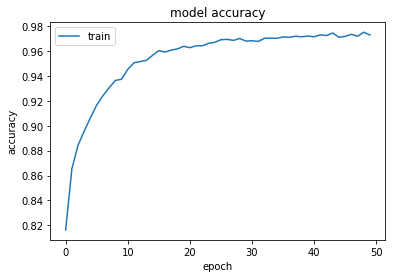

In [18]:
# list all data in history
print(history.history.keys())
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


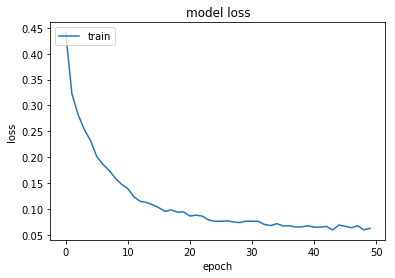

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [21]:
model = load_model('my_model.h5')

In [22]:
def predict(text):
    twt = [text]
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = tokenizer.texts_to_sequences(twt)
    print("text_sequence: ", twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
    print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    if(np.argmax(sentiment) == 0):
        return "negative"
    elif (np.argmax(sentiment) == 1):
        return "positive"

In [23]:
print(predict('Meetings: Because none of us is as dumb as all of us.'))

text_sequence:  [[207, 634, 7, 151, 6, 56, 1053, 56, 47, 7, 151]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  207  634    7  151    6   56 1053   56   47    7  151]]
negative


In [33]:
print(predict('built.io has great connectors'))

text_sequence:  [[60, 147]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  60 147]]
positive


In [25]:
print(predict('downtime of IS server causes slow development at built.io'))

text_sequence:  [[7, 6, 30]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  7  6 30]]
negative
